In [2]:
!pip install git+https://github.com/kazewong/jim

  Cloning https://github.com/kazewong/jim to /tmp/pip-req-build-iskdd0e3
  Running command git clone --filter=blob:none --quiet https://github.com/kazewong/jim /tmp/pip-req-build-iskdd0e3
  Resolved https://github.com/kazewong/jim to commit 03842792626c3a14ec8885f8076833324c391db2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of flowmc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of equinox to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of evosax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requiremen

In [3]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.5.1
    Uninstalling jax-cuda12-pjrt-0.5.1:
      Successfully uninstalled jax-cuda12-pjrt-0.5.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9

In [4]:
!pip install --upgrade equinox

  Using cached equinox-0.13.0-py3-none-any.whl.metadata (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: equinox
    Found existing installation: equinox 0.11.10
    Uninstalling equinox-0.11.10:
      Successfully uninstalled equinox-0.11.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jimgw 0.2.0 requires jax<=0.4.31,>=0.4.24, but you have jax 0.6.2 which is incompatible.


# Importing the modules

In [5]:
import numpy as np
#import jax.numpy as jnp

In [6]:
import time

import jax
import jax.numpy as jnp
# from jax import jit, config
# config.update("jax_disable_jit", True)

from jimgw.jim import Jim
from jimgw.jim import Jim
from jimgw.prior import *
# from jimgw.prior import (
#     CombinePrior,
#     UniformPrior,
#     CosinePrior,
#     SinePrior,
#     PowerLawPrior,
#     UniformSpherePrior,
# )
from jimgw.single_event.detector import H1, L1, V1
from jimgw.single_event.likelihood import TransientLikelihoodFD, HeterodynedTransientLikelihoodFD
from jimgw.single_event.waveform import RippleIMRPhenomD,RippleTaylorF2,RippleIMRPhenomD_NRTidalv2
from jimgw.transforms import BoundToUnbound
from jimgw.single_event.transforms import (
    SkyFrameToDetectorFrameSkyPositionTransform,
    SphereSpinToCartesianSpinTransform,
    MassRatioToSymmetricMassRatioTransform,
    DistanceToSNRWeightedDistanceTransform,
    GeocentricArrivalTimeToDetectorArrivalTimeTransform,
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform,
)
from jimgw.single_event.utils import Mc_q_to_m1_m2
from flowMC.strategy.optimization import optimization_Adam

jax.config.update("jax_enable_x64", True)

###########################################
########## First we grab data #############
###########################################

total_time_start = time.time()

# first, fetch a 4s segment centered on GW150914

gps = 1187008882.43
trigger_time = gps
fmin = 20
fmax = 2048
minimum_frequency = fmin
maximum_frequency = fmax
duration = 128
post_trigger_duration = 2
epoch = duration - post_trigger_duration
f_ref = fmin

ifos = [H1, L1, V1]

H1.frequencies = np.genfromtxt('H1_freq.txt')
H1_data_re, H1_data_im = np.genfromtxt('H1_data_re.txt'), np.genfromtxt('H1_data_im.txt')
H1.data = H1_data_re + 1j * H1_data_im
H1_jnp = jax.numpy.array(H1.frequencies)

L1.frequencies = np.genfromtxt('L1_freq.txt')
L1_data_re, L1_data_im = np.genfromtxt('L1_data_re.txt'), np.genfromtxt('L1_data_im.txt')
L1.data = L1_data_re + 1j * L1_data_im
L1_jnp = jax.numpy.array(L1.frequencies)

V1.frequencies = np.genfromtxt('V1_freq.txt')
V1_data_re, V1_data_im = np.genfromtxt('V1_data_re.txt'), np.genfromtxt('V1_data_im.txt')
V1.data = V1_data_re + 1j * V1_data_im
V1_jnp = jax.numpy.array(V1.frequencies)
# Load the PSD

H1.psd = H1.load_psd(H1_jnp, psd_file ="GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_H1_psd.txt")
L1.psd = L1.load_psd(L1_jnp, psd_file = "GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_L1_psd.txt")
V1.psd = V1.load_psd(V1_jnp, psd_file = "GW170817-IMRD_data0_1187008882-43_generation_data_dump.pickle_V1_psd.txt")

waveform = RippleTaylorF2(f_ref=f_ref)


# Loading the data

# Priors

In [143]:

###########################################
########## Set up priors ##################
###########################################

prior = []


# Mass prior
M_c_min, M_c_max = 1.18, 1.21
q_min, q_max = 0.125, 1.0
Mc_prior = UniformPrior(M_c_min, M_c_max, parameter_names=["M_c"])
q_prior = UniformPrior(q_min, q_max, parameter_names=["q"])

prior = prior + [Mc_prior, q_prior]

# Spin prior
s1_prior = UniformPrior(-0.05, 0.05, parameter_names=["s1_z"])
s2_prior = UniformPrior(-0.05, 0.05, parameter_names=["s2_z"])
lambda_1_prior = UniformPrior(0.0, 5000.0, parameter_names=["lambda_1"])
lambda_2_prior = UniformPrior(0.0, 5000.0, parameter_names=["lambda_2"])

iota_prior = SinePrior(parameter_names=["iota"])

prior = prior + [
    s1_prior,
    s2_prior,
    lambda_1_prior,
    lambda_2_prior,
]

# Extrinsic prior
dL_prior = UniformPrior(1.0, 75.0, parameter_names=["d_L"])
t_c_prior = UniformPrior(-0.1, 0.1, parameter_names=["t_c"])
phase_c_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["phase_c"])
psi_prior = UniformPrior(0.0, jnp.pi, parameter_names=["psi"])
ra_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["ra"])
dec_prior = CosinePrior(parameter_names=["dec"])
#K0_prior=UniformPrior(3000.0,4000.0,parameter_names=["K0"])
#Q0_prior=UniformPrior(3000.0,4000.0,parameter_names=["Q0"])
prior = prior + [
    dL_prior,
    t_c_prior,
    phase_c_prior,
    iota_prior,
    psi_prior,
    ra_prior,
    dec_prior,


]

prior = CombinePrior(prior)
print(prior)
# Defining Transforms

sample_transforms = [
    DistanceToSNRWeightedDistanceTransform(gps_time=gps, ifos=ifos, dL_min=dL_prior.xmin, dL_max=dL_prior.xmax),
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform(gps_time=gps, ifo=ifos[0]),
    GeocentricArrivalTimeToDetectorArrivalTimeTransform(tc_min=t_c_prior.xmin, tc_max=t_c_prior.xmax, gps_time=gps, ifo=ifos[0]),
    SkyFrameToDetectorFrameSkyPositionTransform(gps_time=gps, ifos=ifos),
    BoundToUnbound(name_mapping = (["M_c"], ["M_c_unbounded"]), original_lower_bound=M_c_min, original_upper_bound=M_c_max),
    BoundToUnbound(name_mapping = (["q"], ["q_unbounded"]), original_lower_bound=q_min, original_upper_bound=q_max),
    BoundToUnbound(name_mapping = (["s1_z"], ["s1_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
    BoundToUnbound(name_mapping = (["s2_z"], ["s2_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
    BoundToUnbound(name_mapping = (["lambda_1"], ["lambda_1_unbounded"]) , original_lower_bound=0.0, original_upper_bound=5000.0),
    BoundToUnbound(name_mapping = (["lambda_2"], ["lambda_2_unbounded"]) , original_lower_bound=0.0, original_upper_bound=5000.0),
   # BoundToUnbound(name_mapping = (["iota"], ["iota_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["iota"], ["iota_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["phase_det"], ["phase_det_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
    BoundToUnbound(name_mapping = (["psi"], ["psi_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["zenith"], ["zenith_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
    BoundToUnbound(name_mapping = (["azimuth"], ["azimuth_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
]

likelihood_transforms = [
    MassRatioToSymmetricMassRatioTransform,
]

ref_params = {
    'M_c': 1.1975896,
    'eta': 0.2461001,
    's1_z': -2.96672676e-02,
    's2_z': 2.80404568e-02,
    'lambda_1': 791.04366468,
    'lambda_2': 891.04366468,
    'd_L': 42.86331818,
   't_c': -5.93548230e-05,
   'phase_c': 4.58680356e+00,
   'iota': 2.85,
   'psi': 3.14,
   'ra': 3.44536826,
   'dec': -0.408082,
}



#print(bounds)
likelihood = HeterodynedTransientLikelihoodFD(ifos, waveform=waveform,ref_params =ref_params, n_bins = 1000, trigger_time=trigger_time, duration=duration, post_trigger_duration=post_trigger_duration, prior = prior, sample_transforms = sample_transforms, likelihood_transforms = likelihood_transforms, popsize = 10, n_steps = 50)

eps = 5e-3
n_dim = 13
mass_matrix = jnp.eye(n_dim)
#mass_matrix = mass_matrix.at[0,0].set(1e-5)
mass_matrix = mass_matrix.at[1,1].set(1e-1)
mass_matrix = mass_matrix.at[2,2].set(1e-1)
mass_matrix = mass_matrix.at[3,3].set(1e-1)
# mass_matrix = mass_matrix.at[4,4].set(5.0)
# mass_matrix = mass_matrix.at[5,5].set(5.0)
mass_matrix = mass_matrix.at[6,6].set(2.0)
mass_matrix = mass_matrix.at[7,7].set(1e-4)
mass_matrix = mass_matrix.at[9,9].set(1e-1)
mass_matrix = mass_matrix.at[11,11].set(1e-1)
mass_matrix = mass_matrix.at[12,12].set(1e-1)
local_sampler_arg = {"step_size": mass_matrix * eps}

Adam_optimizer = optimization_Adam(n_steps=3000, learning_rate=0.01, noise_level=1)

import optax
n_chains=1000
n_epochs = 50
n_loop_training = 100
total_epochs = n_epochs * n_loop_training
start = total_epochs // 10
learning_rate = optax.polynomial_schedule(
    1e-3, 1e-4, 4.0, total_epochs - start, transition_begin=start
)

jim = Jim(
    likelihood,
    prior,
    sample_transforms=sample_transforms,
    likelihood_transforms=likelihood_transforms,
    n_loop_training=n_loop_training,
    n_loop_production=50,
    n_local_steps=1000,
    n_global_steps=1000,
    n_chains=n_chains,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    n_max_examples=30000,
    n_flow_sample=100000,
    momentum=0.9,
    batch_size=30000,
    use_global=True,
    keep_quantile=0.0,
    train_thinning=1,
    output_thinning=10,
    local_sampler_arg=local_sampler_arg,
    # strategies=[Adam_optimizer,"default"],
)


jim.sample(jax.random.PRNGKey(42))

Combine(priors=[UniformPrior(xmin=1.18, xmax=1.21, parameter_names=['M_c']), UniformPrior(xmin=0.125, xmax=1.0, parameter_names=['q']), UniformPrior(xmin=-0.05, xmax=0.05, parameter_names=['s1_z']), UniformPrior(xmin=-0.05, xmax=0.05, parameter_names=['s2_z']), UniformPrior(xmin=0.0, xmax=5000.0, parameter_names=['lambda_1']), UniformPrior(xmin=0.0, xmax=5000.0, parameter_names=['lambda_2']), UniformPrior(xmin=1.0, xmax=75.0, parameter_names=['d_L']), UniformPrior(xmin=-0.1, xmax=0.1, parameter_names=['t_c']), UniformPrior(xmin=0.0, xmax=6.283185307179586, parameter_names=['phase_c']), SinePrior(parameter_names=['iota']), UniformPrior(xmin=0.0, xmax=3.141592653589793, parameter_names=['psi']), UniformPrior(xmin=0.0, xmax=6.283185307179586, parameter_names=['ra']), CosinePrior(parameter_names=['dec'])], parameter_names=['M_c', 'q', 's1_z', 's2_z', 'lambda_1', 'lambda_2', 'd_L', 't_c', 'phase_c', 'iota', 'psi', 'ra', 'dec'])
Initializing heterodyned likelihood..
Reference parameters prov

Global Tuning:   0%|          | 0/100 [00:00<?, ?it/s]

Compiling MALA body


Global Sampling: 100%|██████████| 50/50 [06:56<00:00,  8.32s/it]


In [144]:
jim.print_summary()

Training summary
M_c: 1.197 +/- 0.001
d_L: 33.529 +/- 9.377
dec: -0.343 +/- 0.155
iota: 2.327 +/- 0.352
lambda_1: 561.916 +/- 601.137
lambda_2: 760.973 +/- 755.154
phase_c: 3.152 +/- 1.847
psi: 1.191 +/- 0.786
q: 0.883 +/- 0.095
ra: 3.414 +/- 0.285
s1_z: 0.010 +/- 0.023
s2_z: -0.010 +/- 0.025
t_c: -0.000 +/- 0.005
Log probability: 510.132 +/- 873.500
Local acceptance: 0.365 +/- 0.481
Global acceptance: 0.013 +/- 0.113
Max loss: 27.247, Min loss: 2.623
Production summary
M_c: 1.198 +/- 0.000
d_L: 33.625 +/- 7.996
dec: -0.362 +/- 0.040
iota: 2.373 +/- 0.290
lambda_1: 483.536 +/- 414.497
lambda_2: 752.823 +/- 640.071
phase_c: 3.375 +/- 2.041
psi: 1.161 +/- 0.749
q: 0.909 +/- 0.070
ra: 3.424 +/- 0.023
s1_z: 0.014 +/- 0.025
s2_z: -0.017 +/- 0.027
t_c: -0.000 +/- 0.001
Log probability: 525.933 +/- 5.493
Local acceptance: 0.347 +/- 0.476
Global acceptance: 0.020 +/- 0.138


It is working but with high local acceptance

In [145]:

# ###########################################
# ########## Set up priors ##################
# ###########################################

# prior = []


# # Mass prior
# M_c_min, M_c_max = 1.18, 1.21
# q_min, q_max = 0.125, 1.0
# Mc_prior = UniformPrior(M_c_min, M_c_max, parameter_names=["M_c"])
# q_prior = UniformPrior(q_min, q_max, parameter_names=["q"])

# prior = prior + [Mc_prior, q_prior]

# # Spin prior
# s1_prior = UniformPrior(-0.05, 0.05, parameter_names=["s1_z"])
# s2_prior = UniformPrior(-0.05, 0.05, parameter_names=["s2_z"])
# lambda_1_prior = UniformPrior(0.0, 5000.0, parameter_names=["lambda_1"])
# lambda_2_prior = UniformPrior(0.0, 5000.0, parameter_names=["lambda_2"])

# iota_prior = SinePrior(parameter_names=["iota"])

# prior = prior + [
#     s1_prior,
#     s2_prior,
#     lambda_1_prior,
#     lambda_2_prior,
# ]

# # Extrinsic prior
# dL_prior = UniformPrior(1.0, 75.0, parameter_names=["d_L"])
# t_c_prior = UniformPrior(-0.1, 0.1, parameter_names=["t_c"])
# phase_c_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["phase_c"])
# psi_prior = UniformPrior(0.0, jnp.pi, parameter_names=["psi"])
# ra_prior = UniformPrior(0.0, 2 * jnp.pi, parameter_names=["ra"])
# dec_prior = CosinePrior(parameter_names=["dec"])
# #K0_prior=UniformPrior(3000.0,4000.0,parameter_names=["K0"])
# #Q0_prior=UniformPrior(3000.0,4000.0,parameter_names=["Q0"])
# prior = prior + [
#     dL_prior,
#     t_c_prior,
#     phase_c_prior,
#     iota_prior,
#     psi_prior,
#     ra_prior,
#     dec_prior,


# ]

# prior = CombinePrior(prior)
# print(prior)
# # Defining Transforms

# sample_transforms = [
#     DistanceToSNRWeightedDistanceTransform(gps_time=gps, ifos=ifos, dL_min=dL_prior.xmin, dL_max=dL_prior.xmax),
#     GeocentricArrivalPhaseToDetectorArrivalPhaseTransform(gps_time=gps, ifo=ifos[0]),
#     GeocentricArrivalTimeToDetectorArrivalTimeTransform(tc_min=t_c_prior.xmin, tc_max=t_c_prior.xmax, gps_time=gps, ifo=ifos[0]),
#     SkyFrameToDetectorFrameSkyPositionTransform(gps_time=gps, ifos=ifos),
#     BoundToUnbound(name_mapping = (["M_c"], ["M_c_unbounded"]), original_lower_bound=M_c_min, original_upper_bound=M_c_max),
#     BoundToUnbound(name_mapping = (["q"], ["q_unbounded"]), original_lower_bound=q_min, original_upper_bound=q_max),
#     BoundToUnbound(name_mapping = (["s1_z"], ["s1_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
#     BoundToUnbound(name_mapping = (["s2_z"], ["s2_z_unbounded"]) , original_lower_bound=-0.05, original_upper_bound=0.05),
#     BoundToUnbound(name_mapping = (["lambda_1"], ["lambda_1_unbounded"]) , original_lower_bound=0.0, original_upper_bound=5000.0),
#     BoundToUnbound(name_mapping = (["lambda_2"], ["lambda_2_unbounded"]) , original_lower_bound=0.0, original_upper_bound=5000.0),
#    # BoundToUnbound(name_mapping = (["iota"], ["iota_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["iota"], ["iota_unbounded"]) , original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["phase_det"], ["phase_det_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
#     BoundToUnbound(name_mapping = (["psi"], ["psi_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["zenith"], ["zenith_unbounded"]), original_lower_bound=0.0, original_upper_bound=jnp.pi),
#     BoundToUnbound(name_mapping = (["azimuth"], ["azimuth_unbounded"]), original_lower_bound=0.0, original_upper_bound=2 * jnp.pi),
# ]

# likelihood_transforms = [
#     MassRatioToSymmetricMassRatioTransform,
# ]

# ref_params = {
#     'M_c': 1.1975896,
#     'eta': 0.2461001,
#     's1_z': -2.96672676e-02,
#     's2_z': 2.80404568e-02,
#     'lambda_1': 791.04366468,
#     'lambda_2': 891.04366468,
#     'd_L': 42.86331818,
#    't_c': -5.93548230e-05,
#    'phase_c': 4.58680356e+00,
#    'iota': 2.85,
#    'psi': 3.14,
#    'ra': 3.44536826,
#    'dec': -0.408082,
# }



# #print(bounds)
# likelihood = HeterodynedTransientLikelihoodFD(ifos, waveform=waveform,ref_params =ref_params, n_bins = 1000, trigger_time=trigger_time, duration=duration, post_trigger_duration=post_trigger_duration, prior = prior, sample_transforms = sample_transforms, likelihood_transforms = likelihood_transforms, popsize = 10, n_steps = 50)

# eps = 5e-4
# n_dim = 13
# mass_matrix = jnp.eye(n_dim)
# #mass_matrix = mass_matrix.at[0,0].set(1e-5)
# mass_matrix = mass_matrix.at[1,1].set(1e-1)
# mass_matrix = mass_matrix.at[2,2].set(1e-1)
# mass_matrix = mass_matrix.at[3,3].set(1e-1)
# # mass_matrix = mass_matrix.at[4,4].set(5.0)
# # mass_matrix = mass_matrix.at[5,5].set(5.0)
# mass_matrix = mass_matrix.at[6,6].set(2.0)
# mass_matrix = mass_matrix.at[7,7].set(1e-4)
# mass_matrix = mass_matrix.at[9,9].set(1e-1)
# mass_matrix = mass_matrix.at[11,11].set(1e-1)
# mass_matrix = mass_matrix.at[12,12].set(1e-1)
# local_sampler_arg = {"step_size": mass_matrix * eps}


# Adam_optimizer = optimization_Adam(n_steps=3000, learning_rate=0.01, noise_level=1)

# import optax
# n_chains=100
# n_epochs = 20
# n_loop_training = 50
# total_epochs = n_epochs * n_loop_training
# start = total_epochs // 10
# learning_rate = optax.polynomial_schedule(
#     1e-3, 1e-4, 4.0, total_epochs - start, transition_begin=start
# )

# jim = Jim(
#     likelihood,
#     prior,
#     sample_transforms=sample_transforms,
#     likelihood_transforms=likelihood_transforms,
#     n_loop_training=n_loop_training,
#     n_loop_production=20,
#     n_local_steps=500,
#     n_global_steps=1000,
#     n_chains=n_chains,
#     n_epochs=n_epochs,
#     learning_rate=learning_rate,
#     n_max_examples=30000,
#     n_flow_sample=100000,
#     momentum=0.9,
#     batch_size=30000,
#     use_global=True,
#     keep_quantile=0.0,
#     train_thinning=1,
#     output_thinning=5,
#     local_sampler_arg=local_sampler_arg,
#     # strategies=[Adam_optimizer,"default"],
# )


# jim.sample(jax.random.PRNGKey(42))

In [146]:
import numpy as np
#import corner
samples = jim.get_samples()
DL = np.array(samples["d_L"])
np.median(DL),np.std(DL)

(np.float64(34.131642612223985), np.float64(7.9959009729663375))

In [147]:
import numpy as np
import arviz as az



# Step 1: Reshape the samples to simulate multiple chains (assuming 2 chains)
# We split the long array into 2 chains. Adjust the shape as needed.
num_chains = n_chains
num_iterations = len(samples['M_c']) // num_chains  # Total samples / number of chains

samples_reshaped = {param: np.reshape(sample, (num_chains, num_iterations)) for param, sample in samples.items()}

# Step 2: Convert to Arviz InferenceData format
inference_data = az.from_dict(posterior=samples_reshaped)

# Step 3: Calculate Gelman-Rubin (Rhat)
rhat_values = az.rhat(inference_data)
print("Gelman-Rubin (Rhat) Values:\n", rhat_values)

# Step 4: Calculate Effective Sample Size (ESS)
ess_values = az.ess(inference_data)
print("\nEffective Sample Size (ESS):\n", ess_values)

# Optional: Visualize trace and autocorrelation plots
# az.plot_trace(inference_data)
# az.plot_autocorr(inference_data)


Gelman-Rubin (Rhat) Values:
 <xarray.Dataset> Size: 104B
Dimensions:   ()
Data variables: (12/13)
    M_c       float64 8B 1.073
    d_L       float64 8B 1.069
    dec       float64 8B 1.098
    iota      float64 8B 1.074
    lambda_1  float64 8B 1.097
    lambda_2  float64 8B 1.101
    ...        ...
    psi       float64 8B 1.15
    q         float64 8B 1.252
    ra        float64 8B 1.072
    s1_z      float64 8B 1.158
    s2_z      float64 8B 1.196
    t_c       float64 8B 1.078

Effective Sample Size (ESS):
 <xarray.Dataset> Size: 104B
Dimensions:   ()
Data variables: (12/13)
    M_c       float64 8B 9.616e+03
    d_L       float64 8B 8.809e+03
    dec       float64 8B 6.118e+03
    iota      float64 8B 7.958e+03
    lambda_1  float64 8B 6.312e+03
    lambda_2  float64 8B 6.01e+03
    ...        ...
    psi       float64 8B 4.251e+03
    q         float64 8B 2.815e+03
    ra        float64 8B 8.097e+03
    s1_z      float64 8B 4.075e+03
    s2_z      float64 8B 3.425e+03
    t_c  

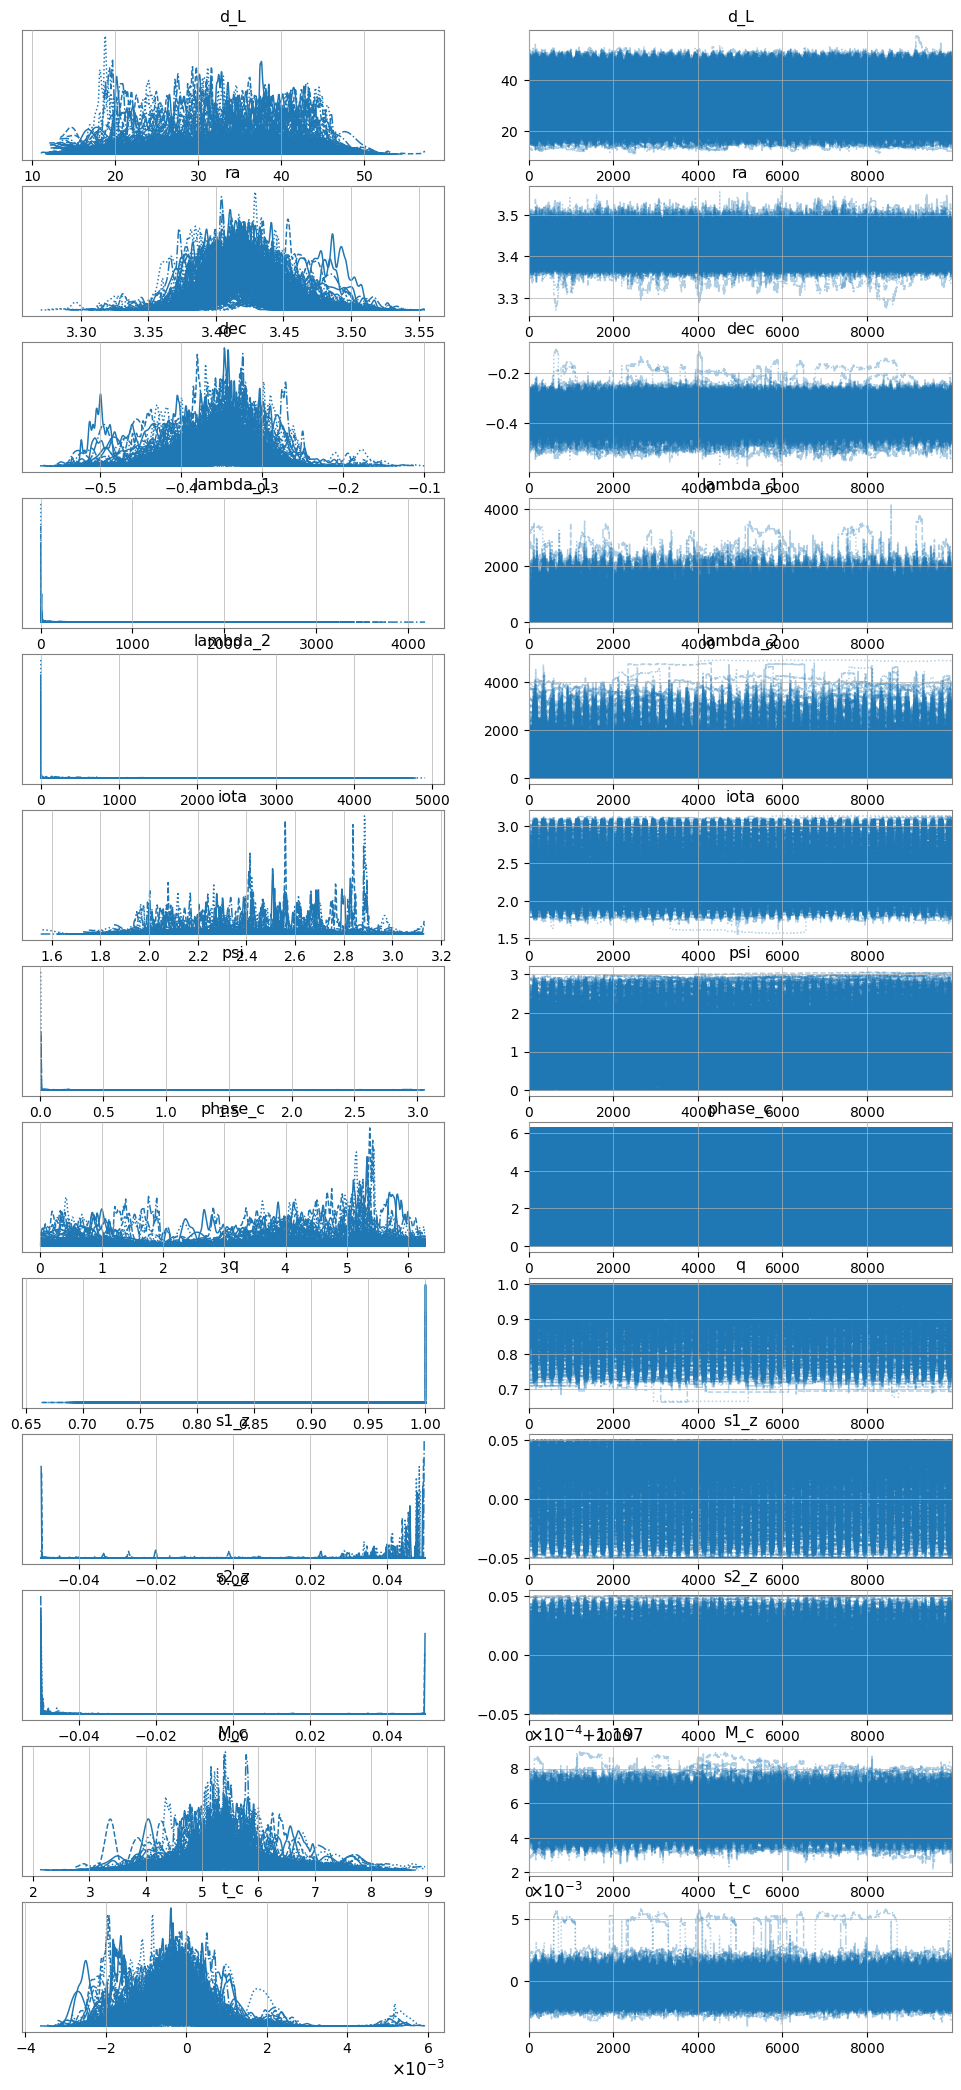

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# Number of chains and draws per chain
n_chains = n_chains
n_draws = len(samples['M_c'])//n_chains

# Reshape your flattened sample array
reshaped = {
    param: np.reshape(samples[param], (n_chains, n_draws))
    for param in samples.keys()
}

# Convert to ArviZ InferenceData
idata = az.from_dict(posterior=reshaped)


# Plot trace
az.plot_trace(idata, var_names=["d_L","ra","dec","lambda_1","lambda_2","iota","psi","phase_c","q", "s1_z", "s2_z", "M_c", "t_c"])
plt.savefig("trace_plot_gr_lam.png")

In [ ]:
# Gelman-Rubin (Rhat) Values:
#  <xarray.Dataset> Size: 104B
# Dimensions:   ()
# Data variables: (12/13)
#     M_c       float64 8B 1.072
#     d_L       float64 8B 1.114
#     dec       float64 8B 1.07
#     iota      float64 8B 1.102
#     lambda_1  float64 8B 1.073
#     lambda_2  float64 8B 1.066
#     ...        ...
#     psi       float64 8B 1.079
#     q         float64 8B 1.084
#     ra        float64 8B 1.073
#     s1_z      float64 8B 1.069
#     s2_z      float64 8B 1.082
#     t_c       float64 8B 1.073

# Effective Sample Size (ESS):
#  <xarray.Dataset> Size: 104B
# Dimensions:   ()
# Data variables: (12/13)
#     M_c       float64 8B 4.254e+03
#     d_L       float64 8B 2.751e+03
#     dec       float64 8B 4.661e+03
#     iota      float64 8B 3.039e+03
#     lambda_1  float64 8B 4.189e+03
#     lambda_2  float64 8B 4.689e+03
#     ...        ...
#     psi       float64 8B 4.11e+03
#     q         float64 8B 3.657e+03
#     ra        float64 8B 4.742e+03
#     s1_z      float64 8B 4.419e+03
#     s2_z      float64 8B 3.754e+03
#     t_c       float64 8B 4.236e+03

In [149]:
import numpy as np
#import corner
samples = jim.get_samples()
DL = np.array(samples["d_L"])
np.median(DL),np.std(DL)

(np.float64(34.131642612223985), np.float64(7.9959009729663375))

In [ ]:
import pandas as pd

df = pd.DataFrame(samples)

# Save the DataFrame to a CSV file
df.to_csv('GW150914_GR_11_PARAM_original_uniform.csv', index=False)

In [150]:
import corner
import matplotlib.pyplot as plt
data = np.vstack([value for value in samples.values()]).T

# Create corner plot
fig = corner.corner(data, labels=list(samples.keys()),title_kwargs={'fontsize': 30},  # Increase title font size
    label_kwargs={'fontsize': 20}, show_titles=True)
plt.savefig("GW170817_GR_11_PARAM.pdf")
# Show the plot
plt.show()

KeyboardInterrupt: 